# About Project 

As part of the Course project i am participating in the Text Classification Competition

**Text Classification Competition: Twitter Sarcasm Detection**



## About data: 
Here we are given  

*   **label** : (SARCASAM and NOT_SARCASM)
*   **Context** : Its a list of tweets data for a conversation. Note, the context is an ordered list of dialogue, i.e., if the context contains three elements, c1, c2, c3, in that order, then c2 is a reply to c1 and c3 is a reply to c2. Further, the Tweet to be classified is a reply to c3.

  For instance, for the following training example :

  "label": "SARCASM", "response": "@USER @USER @USER I don't get this .. obviously you do care or you would've moved right along .. instead you decided to care and troll her ..", "context": ["A minor child deserves privacy and should be kept out of politics . Pamela Karlan , you should be ashamed of your very angry and obviously biased public pandering , and using a child to do it .", "@USER If your child isn't named Barron ... #BeBest Melania couldn't care less . Fact . 💯"]

  The response tweet, "@USER @USER @USER I don't get this..." is a reply to its immediate context "@USER If your child isn't..." which is a reply to "A minor child deserves privacy...". Your goal is to predict the label of the "response" while optionally using the context (i.e, the immediate or the full context).


*   **Response** : Its a response tweet on the last tweet of the context data. This is the tweet to be classified. 
*   **id** : String identifier for sample. This id will be required when making submissions. (ONLY in test data)


There are total 5000 records for training and 1800 records for testing.

## Importing libraries and loading data

Importing all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch
import time
import datetime
import keras
import sklearn
import matplotlib as matplot
import random
import seaborn as sns

Installing the transformers as this library allows to benefits from large, pretrained language models without requiring a huge and costly computational infrastructure.

In [2]:
!pip install transformers

     |████████████████████████████████| 1.4MB 16.0MB/s 
     |████████████████████████████████| 890kB 54.6MB/s 
     |████████████████████████████████| 2.9MB 47.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=04906b4a29f6a3dfcad17413bde0bf9ce2158cd0e36d78a95c34937738758f00
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
print('Pandas Version', pd.__version__)
print('Numpy Version', np.__version__)
print('torch Version', torch.__version__)
print('transformers Version', 'transformers-4.0.1')
print('sklearn Version', sklearn.__version__)
print('matplotlib Version', matplot.__version__)
print('seaborn Version', sns.__version__)
%tensorflow_version
!python --version

Pandas Version 1.1.5
Numpy Version 1.18.5
torch Version 1.7.0+cu101
transformers Version transformers-4.0.1
sklearn Version 0.22.2.post1
matplotlib Version 3.2.2
seaborn Version 0.11.0
Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x
Python 3.6.9


Here i am checking if we have any available running GPU, if yes then use for the processing otherwise we will use the cpu.

In [4]:

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Setting the maximum column width for columns. Cells of this length or longer will be truncated with an ellipsis

In [5]:
pd.set_option('display.max_colwidth', 1000)

Reading the train and test data

**Please ensure to specify the location of the files of train and test data so that the read_json can access and readt it**



In [6]:
train_data = pd.read_json('train.jsonl',lines=True)
test_data = pd.read_json('test.jsonl',lines=True)

See the first few records of Train and test data

In [7]:
train_data.head()

,label,response,context
0,SARCASM,@USER @USER @USER I don't get this .. obviously you do care or you would've moved right along .. instead you decided to care and troll her ..,"[A minor child deserves privacy and should be kept out of politics . Pamela Karlan , you should be ashamed of your very angry and obviously biased public pandering , and using a child to do it ., @USER If your child isn't named Barron ... #BeBest Melania couldn't care less . Fact . 💯]"
1,SARCASM,@USER @USER trying to protest about . Talking about him and his labels and they label themselves WTF does that make em ?,"[@USER @USER Why is he a loser ? He's just a Press Secretary, @USER @USER having to make up excuses of why your crowd was small .]"
2,SARCASM,"@USER @USER @USER He makes an insane about of money from the MOVIES , Einstein ! #LearnHowTheSystemWorks","[Donald J . Trump is guilty as charged . The evidence is clear . If your Senator votes to acquit , remember him / her at the ballot box ., @USER I ’ ll remember to not support you at the box office .]"
3,SARCASM,@USER @USER Meanwhile Trump won't even release his SAT scores and his Wharton professors said he was the dumbest student they've ever taught,"[Jamie Raskin tanked Doug Collins . Collins looks stupid . <URL>, @USER But not half as stupid as Schiff looks . People's looks are what nature creates . Abilities of people are what they create for themselves . Just for looks , Lincoln was not tops but with his education and understanding made him great .]"
4,SARCASM,"@USER @USER Pretty Sure the Anti-Lincoln Crowd Claimed That "" Democracy Was on the Ballot "" in 1860 , too . They Thought Lincoln Was "" Authoritarian "" . #GOP #PartyOfLincoln #Democrats","[Man ... y ’ all gone “ both sides ” the apocalypse one day . <URL>, @USER They already did . Obama said many times during the 2016 campaign that democracy was on the ballot . Then . Hillary warned you , so did every single expert in authoritarianism . The media , like millions of Americans , refused to believe them .]"


In [8]:
test_data.head()

,id,response,context
0,twitter_1,"@USER @USER @USER My 3 year old , that just finished reading Nietzsche and then asked me : "" ayo papa why these people always trying to cancel someone on Twitter , trying to pretend like that makes them better themselves ? "" . To which I replied "" idk "" , and he just "" cuz hoes mad "" . Im so proud . <URL>","[Well now that ’ s problematic AF <URL>, @USER @USER My 5 year old ... asked me why they are making fun of Native Americans .., @USER @USER @USER I will take shit that didn't happen for $ 100, @USER @USER @USER No .. he actually in the gifted program and reads on second grade level . ... and he knows Kansas City is in Missouri]"
1,twitter_2,"@USER @USER How many verifiable lies has he told now ? 15,000+ documented . He's a truth teller for sure .","[Last week the Fake News said that a section of our powerful , under construction , Southern Border Wall “ fell over ” , trying to make it sound terrible , except the reason was that the concrete foundation was just poured & soaking wet when big winds kicked in . Quickly fixed “ forever ” ., @USER The mainstream media doesn't report the facts ; yet , the truth is available from the current resident of 1600 Pennsylvania Avenue , Washington D . C . ~]"
2,twitter_3,@USER @USER @USER Maybe Docs just a scrub of a coach ... I mean to get hammered with that gold standard team,"[@USER Let ’ s Aplaud Brett When he deserves it he coached an amazing game <URL>, @USER @USER He did try keep korkmaz in in the 4th quarter when he was a defensive liability . And Sixers had a shit clock violation AFTER a timeout . And kept horford w embiid while clippers went small ball . And Scott over Robinson was not very smart . But for bretts standards ... <URL>]"
3,twitter_4,@USER @USER is just a cover up for the real hate inside @USER . The left in a nutshell ! <URL>,"[Women generally hate this president . What's up with men ?, @USER I've hated him before he was placed in office , now I hate all his enablers as much as him , you woman will save this country and our world . Some of us men know that , are ok with that , admire that and will help with that .]"
4,twitter_5,@USER @USER @USER The irony being that he even has to ask why .,"[Dear media Remoaners , you excitedly sharing clips of ordinary Brexit voters struggling to articulate themselves as well as they might on live TV proves nothing about them or the Brexit vote . It just proves you lot are petty , snobbish c * * * s ., @USER When Spiked claim that Brexiteers knew exactly what they were voting for , it's quite obviously untrue in many cases . It's not snobbery - but let's be honest about the fact that , on both sides of t debate , there was a lot of ignorance . #thick, @USER @USER Quite an articulate and considered comment but then finishes with ' that ' hashtag proving that he's still a #twat]"


Creating a new numerical column which will translate if its *SARCASM* then value is 1 otherwise its 0 

In [9]:
train_data['num_label'] = np.where(train_data['label']=='SARCASM',1,0)

## Pre Processing of text data

In this step created a function for removing the few words like '@user', '...' and 'url'. Here i am passing *response* column of the row of the dataframe and splitting it into unigram tokens and striping it.

Calling this function on Train and test data

In [10]:
custom_list = ['@user','..','<url>']
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in custom_list:
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = remove_stopwords(text)
    return text

In [11]:
train_data['new_response']=train_data['response'].apply(denoise_text)

In [12]:
test_data['new_response']=test_data['response'].apply(denoise_text)

In [13]:
sentences = train_data['new_response'].values
labels = train_data['num_label'].values

In [14]:
test_sentences = test_data['new_response'].values

In [15]:
print('sample showing the processed train data')
sentences[0], labels[0]

sample showing the processed train data


("i don't get this obviously you do care or you would've moved right along instead you decided to care and troll her",
 1)

In [16]:
print('sample showing the processed train data')
test_sentences[0]

sample showing the processed train data


'my 3 year old , that just finished reading nietzsche and then asked me : " ayo papa why these people always trying to cancel someone on twitter , trying to pretend like that makes them better themselves ? " . to which i replied " idk " , and he just " cuz hoes mad " . im so proud .'

importing BertTokenizer to load the pre-trained model tokenizer (vocabulary)

In [17]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Showing sample record after the tokenization 

In [18]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  i don't get this obviously you do care or you would've moved right along instead you decided to care and troll her
Tokenized:  ['i', 'don', "'", 't', 'get', 'this', 'obviously', 'you', 'do', 'care', 'or', 'you', 'would', "'", 've', 'moved', 'right', 'along', 'instead', 'you', 'decided', 'to', 'care', 'and', 'troll', 'her']
Token IDs:  [1045, 2123, 1005, 1056, 2131, 2023, 5525, 2017, 2079, 2729, 2030, 2017, 2052, 1005, 2310, 2333, 2157, 2247, 2612, 2017, 2787, 2000, 2729, 1998, 18792, 2014]


### encoding
Created a encoding function to encode every sentence such that it starts with word 'CLS' and end with 'SEP'  and map to their encoding id this is a prerequiste for the model.

Running the function for train and test data


In [19]:
def encoding (sentences):
  input_ids = []
  for sent in sentences:
      encoded_sent = tokenizer.encode(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                    )
      input_ids.append(encoded_sent)
  return input_ids

In [20]:
input_ids = encoding (sentences)

print('sample from train set \n')
# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])


test_input_ids = encoding (test_sentences)

print('\n sample from test set \n')
# Print sentence 0, now as a list of IDs.
print('\n Original: ', test_sentences[0])
print('Token IDs:', test_input_ids[0])

sample from train set 

Original:  i don't get this obviously you do care or you would've moved right along instead you decided to care and troll her
Token IDs: [101, 1045, 2123, 1005, 1056, 2131, 2023, 5525, 2017, 2079, 2729, 2030, 2017, 2052, 1005, 2310, 2333, 2157, 2247, 2612, 2017, 2787, 2000, 2729, 1998, 18792, 2014, 102]

 sample from test set 


 Original:  my 3 year old , that just finished reading nietzsche and then asked me : " ayo papa why these people always trying to cancel someone on twitter , trying to pretend like that makes them better themselves ? " . to which i replied " idk " , and he just " cuz hoes mad " . im so proud .
Token IDs: [101, 2026, 1017, 2095, 2214, 1010, 2008, 2074, 2736, 3752, 28898, 1998, 2059, 2356, 2033, 1024, 1000, 1037, 7677, 13008, 2339, 2122, 2111, 2467, 2667, 2000, 17542, 2619, 2006, 10474, 1010, 2667, 2000, 9811, 2066, 2008, 3084, 2068, 2488, 3209, 1029, 1000, 1012, 2000, 2029, 1045, 3880, 1000, 8909, 2243, 1000, 1010, 1998, 2002, 2074, 1000,

In [21]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  88


In [22]:
print('Max sentence length: ', max([len(sen) for sen in test_input_ids]))

Max sentence length:  81


### padding data

Padding the train and test data with 0 with the max length per the training data. This is a pre requisite for model to have a fixed length of all the data records.This is one of the hyperparameter and i have tried various values and 88 seems to work best. 

In [23]:
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
MAX_LEN = 88

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# FOR training data
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

# FOR testing data

test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


Padding/truncating all sentences to 88 values...

Padding token: "[PAD]", ID: 0


### creating attention mask

Creating a attention mask for train and test data which is needed for the model
*   if a token ID is 0, then it's padding, set the mask to 0.
*   If a token ID is > 0, then it's a real token, set the mask to 1.

In [24]:
# FOR TRAINING
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    
    attention_masks.append(att_mask)

In [25]:
# FOR TESTING
# Create attention masks
test_attention_masks = []

for sent in test_input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    test_attention_masks.append(att_mask)

In [26]:
# Use train_test_split to split our data into train and validation sets for
# training
# better results got with 2018
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

### Converting data to torch tensor

Convert all inputs and labels into torch tensors, the required datatype for our model.

In [27]:
# FOR TRAINING

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)


train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)


In [28]:
# FOR TESTING
test_input_ids = torch.tensor(test_input_ids)
test_attention_masks = torch.tensor(test_attention_masks)

### Creating dataloader

In [29]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# FOR TRAINING AND VALIDATION
# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [30]:
# FOR TESTING

testing_data = TensorDataset(test_input_ids, test_attention_masks)
test_sampler = SequentialSampler(testing_data)
test_dataloader = DataLoader(testing_data, sampler=test_sampler, batch_size=batch_size)

## Loading BertForSequenceClassification model

In [31]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

The original Adam algorithm was proposed in [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980). The AdamW variant was proposed in [Decoupled Weight Decay Regularization](https://arxiv.org/abs/1711.05101).

In [32]:

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

Tried different epochs as we are increasing the epochs the model was overfitting. 5 seems to work well for me.

## Creating Scheduler

In [33]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score

Function to calculate the accuracy of our predictions vs labels

In [34]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [35]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


## Training and validation of the model

In [36]:

# This training code is based on the `run_glue.py` script here and modified based on the need of this project:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    141.    Elapsed: 0:00:20.
  Batch    80  of    141.    Elapsed: 0:00:40.
  Batch   120  of    141.    Elapsed: 0:01:02.

  Average training loss: 0.51
  Training epcoh took: 0:01:13

Running Validation...
  Accuracy: 0.80
  Validation took: 0:00:03

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    141.    Elapsed: 0:00:21.
  Batch    80  of    141.    Elapsed: 0:00:42.
  Batch   120  of    141.    Elapsed: 0:01:03.

  Average training loss: 0.37
  Training epcoh took: 0:01:14

Running Validation...
  Accuracy: 0.77
  Validation took: 0:00:03

======== Epoch 3 / 5 ========
Training...
  Batch    40  of    141.    Elapsed: 0:00:21.
  Batch    80  of    141.    Elapsed: 0:00:42.
  Batch   120  of    141.    Elapsed: 0:01:03.

  Average training loss: 0.25
  Training epcoh took: 0:01:14

Running Validation...
  Accuracy: 0.81
  Validation took: 0:00:03

======== Epoch 4 / 5 ========
Training...
  Batch    40  of 

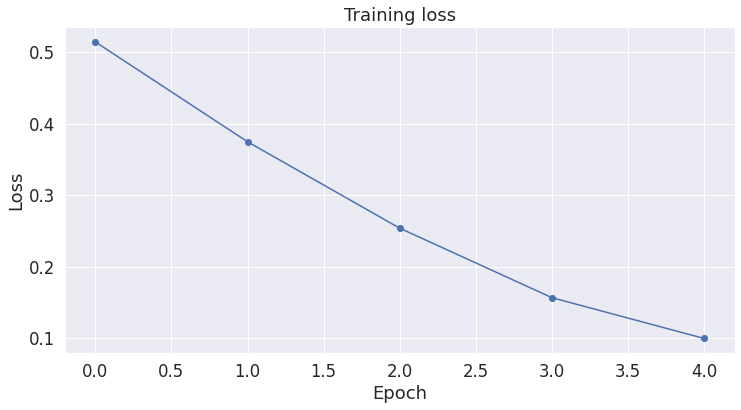

In [37]:

% matplotlib inline

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
matplot.pyplot.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
matplot.pyplot.plot(loss_values, 'b-o')

# Label the plot.
matplot.pyplot.title("Training loss")
matplot.pyplot.xlabel("Epoch")
matplot.pyplot.ylabel("Loss")

matplot.pyplot.show()

## Prediction on testing data

Now our model is trained we are going to make prediction on our test dataset.

In [38]:
# FOR TESTING

model.eval()
test_log =[]

# Evaluate data for one epoch
for batch in test_dataloader:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch
    
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # Get the "logits" output by the model. The "logits" are the output
    # values prior to applying an activation function like the softmax.
    logits = outputs[0]
    
    # Move logits and labels to CPU
    #test_logits = logits.detach().cpu().numpy()
    test_log.append(logits)        

In [39]:
all_logits = torch.cat(test_log, dim=0)
probs = F.softmax(all_logits, dim=1).cpu().numpy()
print('probabilities of Non_SARCASAM and SARCASAM')
probs

probabilities of Non_SARCASAM and SARCASAM


array([[0.36360136, 0.6363987 ],
       [0.01824608, 0.9817539 ],
       [0.01425592, 0.98574406],
       ...,
       [0.13947845, 0.8605215 ],
       [0.9974612 , 0.00253878],
       [0.99606234, 0.00393763]], dtype=float32)

Converting the prediction based on the *threshold value* which we are saying 0.5 for now. I have tried different values as well but 0.5 was giving better results.

In [40]:
threshold = 0.5
final_pred = np.where(probs[:, 1] >= threshold, 'SARCASM', 'NOT_SARCASM')

## Generating output file

Concatinating the out for the test data. We are taking the id and adding the prediction calculated above and writing it on a '*answer.txt*' file

In [41]:
results = pd.DataFrame(test_data['id'])
results['label']=final_pred
results.to_csv('answer.txt',index=False, header=False)

## References

*   https://www.youtube.com/watch?v=FKlPCK1uFrc&list=PLam9sigHPGwOBuH4_4fr-XvDbe5uneaf6&index=1
*   https://mccormickml.com/2019/07/22/BERT-fine-tuning/#5-performance-on-test-set
*   https://skimai.com/fine-tuning-bert-for-sentiment-analysis/
*   http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
*   https://colab.research.google.com/github/huggingface/transformers/blob/master/notebooks/02-transformers.ipynb#scrollTo=TFHTP6CFSXai





